In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
df=pd.read_excel('Bariatric Project Study Data 2025_mod.xlsx', sheet_name='Sheet1')

In [3]:
core_X_data=df[['gender', 'age', 'height', 'weight', 'bmi', 'family_hist_cnt', 'chronic_meds_cnt','procedure_category','antibiotics','cholecystectomy_repair','hiatus_hernia_repair']].copy()
cm_cols= [col for col in df.columns if col.startswith('CM_')]

cm_data = df[cm_cols].fillna(0).astype(int)
cm_data
zero_only = [col for col in cm_data.columns if (cm_data[col] == 0).all()]
cm_data = cm_data.drop(columns=zero_only)

# finally, join the filtered CM_ data back into your core set
core_X_data = core_X_data.join(cm_data)
core_X_data.fillna(0, inplace=True)
print(core_X_data.isna().sum())  # should all be zero   

# inspect result
print("Dropped CM columns:", zero_only)
print("Remaining columns in CM data:", cm_data.columns.tolist())
# 1) Grab all the antibiotic dummy columns
ab_cols = [c for c in core_X_data.columns if c.startswith('antibiotics')]

# 2) Count zeros in each column
for col in ab_cols:
    n_zeros = (core_X_data[col] == 0).sum()
    print(f"{col}: {n_zeros} zeros out of {len(core_X_data)} rows")

# 3) (Bonus) How many rows have *no* antibiotic flagged?
no_ab_rows = (core_X_data[ab_cols].sum(axis=1) == 0).sum()
print(f"\nRows where ALL antibiotic dummies are 0 (i.e. original 0): {no_ab_rows}")



gender                    0
age                       0
height                    0
weight                    0
bmi                       0
family_hist_cnt           0
chronic_meds_cnt          0
procedure_category        0
antibiotics               0
cholecystectomy_repair    0
hiatus_hernia_repair      0
CM_AIDS                   0
CM_ANEMDEF                0
CM_ARTH                   0
CM_CHF                    0
CM_DEPRESS                0
CM_DM                     0
CM_DMCX                   0
CM_HTN_C                  0
CM_HYPOTHY                0
CM_LIVER                  0
CM_OBESE                  0
CM_PSYCH                  0
CM_SMOKE                  0
CM_APNEA                  0
CM_CHOLSTRL               0
CM_OSTARTH                0
CM_HPLD                   0
dtype: int64
Dropped CM columns: ['CM_ALCOHOL', 'CM_BLDLOSS', 'CM_CHRNLUNG', 'CM_COAG', 'CM_DRUG', 'CM_LYMPH', 'CM_LYTES', 'CM_METS', 'CM_NEURO', 'CM_PARA', 'CM_PERIVASC', 'CM_PULMCIRC', 'CM_RENLFAIL', 'CM_TUMOR', 'C

In [4]:
# Check whether CM_NEURO survived the filtering
if 'CM_CHF' in core_X_data.columns:
    print("CM_CHF is present in core_X_data!")
else:
    
    print("CM_CHFis NOT in core_X_data.")
if 'CM_DRUG' in core_X_data.columns:
    print("CM_NEURO is present in core_X_data!")
else:
    print("CM_NEURO is NOT in core_X_data.")


CM_CHF is present in core_X_data!
CM_NEURO is NOT in core_X_data.


In [5]:
# Identify all complication-related columns
comp_cols = [col for col in df.columns if 'comp' in col.lower()]

# Create new dataset without the original complication columns
df_new = df.drop(columns=comp_cols)

# Add a single 'complication' column: 1 if any original comp column == 1, else 0
df_new['complication'] = (df[comp_cols] == 1).any(axis=1).astype(int)

# Display new dataset shape
print("New dataset shape (rows, columns):", df_new.shape)

# Show a sample of the new 'complication' column alongside the ID
# Show the first 10 rows of id and complication
print(df_new[['id', 'complication']].head(10))
print("First 15 column names:", df_new.columns.tolist())

New dataset shape (rows, columns): (344, 111)
        id  complication
0  45488.0             0
1      NaN             0
2  37462.0             1
3  40661.0             0
4      NaN             0
5  40699.0             0
6  38920.0             0
7  37827.0             0
8  47189.0             0
9      NaN             0
First 15 column names: ['doctor', 'procedure_category', 'hospitalDesc', 'hospital_wardDesc', 'days_since_admission', 'length_of_stay', 'gender', 'age', 'weight', 'height', 'bmi', 'family_hist_cnt', 'chronic_meds_cnt', 'cm_count', 'morbidity', 'CM_AIDS', 'CM_ALCOHOL', 'CM_ANEMDEF', 'CM_ARTH', 'CM_BLDLOSS', 'CM_CHF', 'CM_CHRNLUNG', 'CM_COAG', 'CM_DEPRESS', 'CM_DM', 'CM_DMCX', 'CM_DRUG', 'CM_HTN_C', 'CM_HYPOTHY', 'CM_LIVER', 'CM_LYMPH', 'CM_LYTES', 'CM_METS', 'CM_NEURO', 'CM_OBESE', 'CM_PARA', 'CM_PERIVASC', 'CM_PSYCH', 'CM_PULMCIRC', 'CM_RENLFAIL', 'CM_SMOKE', 'CM_TUMOR', 'CM_ULCER', 'CM_VALVE', 'CM_WGHTLOSS', 'CM_APNEA', 'CM_CHOLSTRL', 'CM_OSTARTH', 'CM_HPLD', 'emergency_

In [6]:
# Missing values analysis
missing_df = pd.DataFrame({
    'Missing_Count': core_X_data.isnull().sum(),
    'Missing_Percentage': (core_X_data.isnull().sum() / len(core_X_data)) * 100
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

print("="*50)
print("MISSING VALUES ANALYSIS")
print("="*50)
print(f"Columns with missing values: {len(missing_df)}/{core_X_data.shape[1]}")
print(f"Total completeness: {(1 - core_X_data.isnull().sum().sum()/(core_X_data.shape[0]*core_X_data.shape[1]))*100:.1f}%")

if len(missing_df) > 0:
    print("\nTop missing columns:")
    print(missing_df.head(10))
    
    # Visualization
    plt.figure(figsize=(10, 6))
    top_missing = missing_df.head(15)
    plt.barh(range(len(top_missing)), top_missing['Missing_Percentage'], color='coral')
    plt.yticks(range(len(top_missing)), top_missing.index)
    plt.xlabel('Missing Percentage (%)')
    plt.title('Top 15 Columns with Missing Values', fontsize=14, fontweight='bold')
    
    for i, v in enumerate(top_missing['Missing_Percentage']):
        plt.text(v + 0.1, i, f'{v:.1f}%', va='center')
    
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found!")

MISSING VALUES ANALYSIS
Columns with missing values: 0/28
Total completeness: 100.0%
No missing values found!


In [7]:
core_Y_data=df_new[["complication"]]

core_Y_data.head()

,complication
0,0
1,0
2,1
3,0
4,0


In [8]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
X = core_X_data.copy()
y = core_Y_data['complication'].values

# Handle categorical variables first
categorical_cols = X.select_dtypes(include=['object']).columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)


# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=102, stratify=y
)

print("Class distribution in training set:")
print(f"No complications: {(y_train==0).sum()} ({(y_train==0).sum()/len(y_train)*100:.1f}%)")
print(f"Complications: {(y_train==1).sum()} ({(y_train==1).sum()/len(y_train)*100:.1f}%)")
print(f"\nClass distribution in test set:")
print(f"No complications: {(y_test==0).sum()} ({(y_test==0).sum()/len(y_test)*100:.1f}%)")
print(f"Complications: {(y_test==1).sum()} ({(y_test==1).sum()/len(y_test)*100:.1f}%)")
X_encoded.head()

Class distribution in training set:
No complications: 248 (90.2%)
Complications: 27 (9.8%)

Class distribution in test set:
No complications: 62 (89.9%)
Complications: 7 (10.1%)


,age,height,weight,bmi,family_hist_cnt,chronic_meds_cnt,cholecystectomy_repair,hiatus_hernia_repair,CM_AIDS,CM_ANEMDEF,...,procedure_category_BPD -DS,procedure_category_Mini gastric bypass (OAGB),procedure_category_RYGBP,procedure_category_SADI,procedure_category_Sleeve,antibiotics_Augmentin,antibiotics_Clindamycin,antibiotics_Invanz,antibiotics_Kefsol,antibiotics_Rocephin
0,50,154,146.0,61.56,0,0,0.0,0.0,0,0,...,False,False,False,True,False,False,False,False,True,False
1,52,168,96.0,34.00,0,0,1.0,0.0,0,0,...,False,False,False,False,True,False,False,False,True,False
2,23,163,143.0,53.82,0,0,0.0,1.0,0,0,...,False,False,False,True,False,False,False,False,True,False
3,23,176,120.0,38.74,0,0,0.0,1.0,0,0,...,False,False,False,False,True,False,False,False,True,False
4,57,162,112.0,42.68,0,7,0.0,1.0,0,0,...,False,False,False,True,False,False,False,False,True,False


In [10]:
for col in X_encoded.columns:
    print(col)

age
height
weight
bmi
family_hist_cnt
chronic_meds_cnt
cholecystectomy_repair
hiatus_hernia_repair
CM_AIDS
CM_ANEMDEF
CM_ARTH
CM_CHF
CM_DEPRESS
CM_DM
CM_DMCX
CM_HTN_C
CM_HYPOTHY
CM_LIVER
CM_OBESE
CM_PSYCH
CM_SMOKE
CM_APNEA
CM_CHOLSTRL
CM_OSTARTH
CM_HPLD
gender_Male
procedure_category_BPD -DS
procedure_category_Mini gastric bypass (OAGB)
procedure_category_RYGBP
procedure_category_SADI
procedure_category_Sleeve
antibiotics_Augmentin
antibiotics_Clindamycin
antibiotics_Invanz
antibiotics_Kefsol
antibiotics_Rocephin


In [9]:
# Create baseline model
baseline_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Train and evaluate
baseline_pipeline.fit(X_train, y_train)
y_pred_baseline = baseline_pipeline.predict(X_test)
y_pred_proba_baseline = baseline_pipeline.predict_proba(X_test)[:, 1]

print("BASELINE MODEL (No imbalance handling):")
print("="*50)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_baseline):.3f}")

# Confusion matrix
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
print(f"\nConfusion Matrix:")
print(f"TN: {cm_baseline[0,0]}, FP: {cm_baseline[0,1]}")
print(f"FN: {cm_baseline[1,0]}, TP: {cm_baseline[1,1]}")
print(f"Sensitivity (Recall): {cm_baseline[1,1]/(cm_baseline[1,0]+cm_baseline[1,1]):.1%}")
print(f"Specificity: {cm_baseline[0,0]/(cm_baseline[0,0]+cm_baseline[0,1]):.1%}")

BASELINE MODEL (No imbalance handling):

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92        62
           1       0.00      0.00      0.00         7

    accuracy                           0.86        69
   macro avg       0.45      0.48      0.46        69
weighted avg       0.80      0.86      0.83        69

ROC-AUC Score: 0.698

Confusion Matrix:
TN: 59, FP: 3
FN: 7, TP: 0
Sensitivity (Recall): 0.0%
Specificity: 95.2%


In [10]:
# Alternative: Using class weights instead of resampling
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weight_dict = {0: class_weights[0], 1: class_weights[1]}

print("Class weights approach:")
print(f"Class 0 weight: {class_weights[0]:.2f}")
print(f"Class 1 weight: {class_weights[1]:.2f}")

# Train model with class weights
weighted_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
])

weighted_model.fit(X_train, y_train)
y_pred_weighted = weighted_model.predict(X_test)
y_pred_proba_weighted = weighted_model.predict_proba(X_test)[:, 1]

print("\nClass Weights Model Performance:")
print(classification_report(y_test, y_pred_weighted))
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_weighted):.3f}")

Class weights approach:
Class 0 weight: 0.55
Class 1 weight: 5.09

Class Weights Model Performance:
              precision    recall  f1-score   support

           0       0.91      0.68      0.78        62
           1       0.13      0.43      0.20         7

    accuracy                           0.65        69
   macro avg       0.52      0.55      0.49        69
weighted avg       0.83      0.65      0.72        69

ROC-AUC: 0.645


Default threshold: 0.5
Optimal threshold: 0.393
F1 at optimal: 0.316


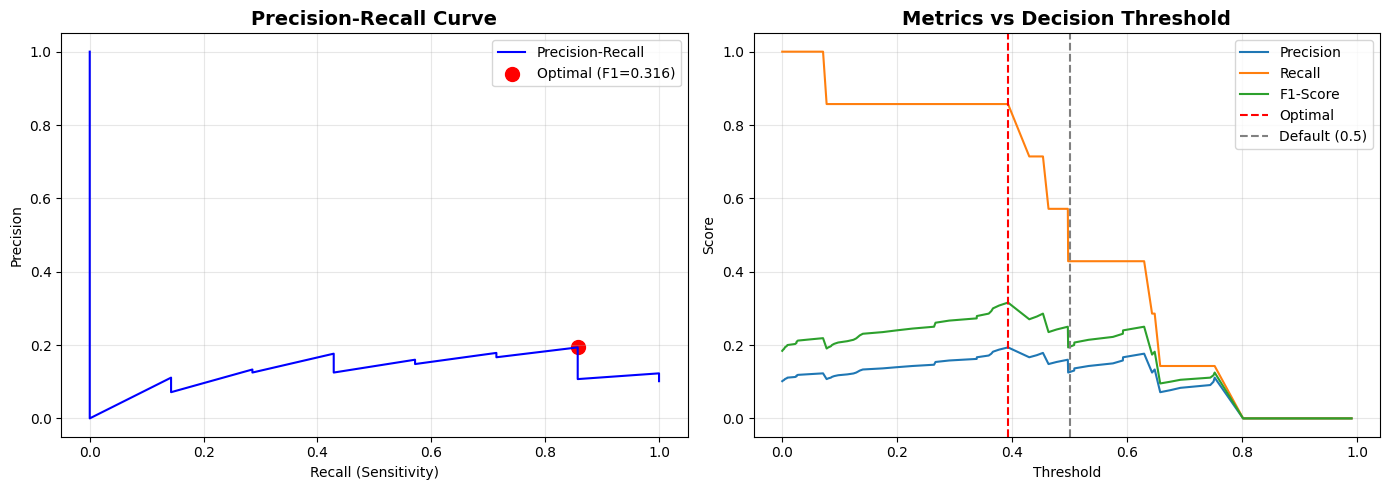


Performance with optimal threshold:
              precision    recall  f1-score   support

           0       0.92      0.77      0.84        62
           1       0.18      0.43      0.25         7

    accuracy                           0.74        69
   macro avg       0.55      0.60      0.55        69
weighted avg       0.85      0.74      0.78        69



In [11]:
from sklearn.metrics import precision_recall_curve

# Get probabilities for class weights model
y_proba = weighted_model.predict_proba(X_test)[:, 1]

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Find optimal threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Default threshold: 0.5")
print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"F1 at optimal: {f1_scores[optimal_idx]:.3f}")

# Plot threshold analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Precision-Recall curve
ax1.plot(recall, precision, 'b-', label='Precision-Recall')
ax1.scatter(recall[optimal_idx], precision[optimal_idx], 
           color='red', s=100, label=f'Optimal (F1={f1_scores[optimal_idx]:.3f})')
ax1.set_xlabel('Recall (Sensitivity)')
ax1.set_ylabel('Precision')
ax1.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Threshold vs Metrics
ax2.plot(thresholds, precision[:-1], label='Precision')
ax2.plot(thresholds, recall[:-1], label='Recall')
ax2.plot(thresholds, f1_scores[:-1], label='F1-Score')
ax2.axvline(x=optimal_threshold, color='red', linestyle='--', label='Optimal')
ax2.axvline(x=0.5, color='gray', linestyle='--', label='Default (0.5)')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Score')
ax2.set_title('Metrics vs Decision Threshold', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test with optimal threshold
y_pred_optimal = (y_proba >= 0.61).astype(int)
print("\nPerformance with optimal threshold:")
print(classification_report(y_test, y_pred_optimal))

In [12]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    precision_recall_curve,
    classification_report,
    confusion_matrix,
    roc_auc_score
)

# 1) Compute “balanced” weights (or tweak them by hand)
balanced_ws = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
# balanced_ws might look like [0.53, 4.47]

# Option A: use these as-is
#weight_dict = {0: balanced_ws[0], 1: balanced_ws[1]}

# Option B: up‐weight the minority even more, e.g. ×2
weight_dict = {0: balanced_ws[0], 1: balanced_ws[1] * 2}

print("Using class weights:", weight_dict)

# 2) Build & fit the RF pipeline
#    (RF doesn’t actually need scaling, but we include it for parity)
rf_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(
        n_estimators=200,
        class_weight=weight_dict,
        random_state=42,
        n_jobs=-1
    ))
])

rf_pipe.fit(X_train, y_train)

# 3) Get predicted probabilities
y_proba_rf = rf_pipe.predict_proba(X_test)[:, 1]

# 4) Find the threshold that maximizes F1 on the test set
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_rf)
f1_scores = 2 * precision * recall / (precision + recall + 1e-10)

# align lengths: thresholds is len(precision)-1
best_idx = np.argmax(f1_scores[:-1])
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\nDefault threshold: 0.5")
print(f"Optimal threshold: {best_thresh:.3f} → F1 = {best_f1:.3f}")

# 5) Evaluate at default vs. optimal
for thresh in [0.5, best_thresh]:
    y_pred = (y_proba_rf >= thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f"\n––– Threshold = {thresh:.2f} –––")
    print(f"TP={tp}, FN={fn}, FP={fp}, TN={tn}")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC (unchanged): {roc_auc_score(y_test, y_proba_rf):.3f}")


Using class weights: {0: 0.5544354838709677, 1: 10.185185185185185}

Default threshold: 0.5
Optimal threshold: 0.365 → F1 = 0.444

––– Threshold = 0.50 –––
TP=0, FN=7, FP=0, TN=62
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        62
           1       0.00      0.00      0.00         7

    accuracy                           0.90        69
   macro avg       0.45      0.50      0.47        69
weighted avg       0.81      0.90      0.85        69

ROC-AUC (unchanged): 0.680

––– Threshold = 0.36 –––
TP=2, FN=5, FP=0, TN=62
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        62
           1       1.00      0.29      0.44         7

    accuracy                           0.93        69
   macro avg       0.96      0.64      0.70        69
weighted avg       0.93      0.93      0.91        69

ROC-AUC (unchanged): 0.680


In [16]:
!pip install lightgbm


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [18]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# XGBoost with tuned parameters for small, imbalanced data
xgb_model = XGBClassifier(
    scale_pos_weight=9.1,  # Your imbalance ratio
    max_depth=3,           # Shallow trees for small data
    n_estimators=100,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,               # Higher gamma for conservative splits
    random_state=42
)

# LightGBM alternative
lgbm_model = LGBMClassifier(
    is_unbalance=True,
    max_depth=3,
    n_estimators=100,
    num_leaves=7,          # Small for your dataset
    min_child_samples=5,   # Prevent overfitting
    random_state=42
)

In [19]:
from sklearn.svm import SVC

svm_model = SVC(
    kernel='rbf',
    class_weight='balanced',
    probability=True,      # For ROC-AUC
    C=1.0,
    gamma='scale',
    random_state=42
)

In [20]:
from sklearn.linear_model import SGDClassifier

elastic_net = SGDClassifier(
    loss='log_loss',
    penalty='elasticnet',
    class_weight='balanced',
    alpha=0.001,
    l1_ratio=0.5,          # Balance between L1 and L2
    random_state=42
)

In [21]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB

# For continuous features
gnb_model = GaussianNB()

# For binary features (your CM_ columns)
bnb_model = BernoulliNB(alpha=1.0)

In [22]:
from sklearn.ensemble import VotingClassifier, StackingClassifier

# Voting ensemble of your best models
voting_model = VotingClassifier(
    estimators=[
        ('lr', weighted_model),
        ('xgb', xgb_model),
        ('svm', svm_model)
    ],
    voting='soft'  # Use probabilities
)

# Stacking with logistic regression meta-model
stacking_model = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(class_weight='balanced')),
        ('xgb', xgb_model),
        ('nb', gnb_model)
    ],
    final_estimator=LogisticRegression(class_weight='balanced'),
    cv=5  # Use cross-validation for training meta-model
)

In [23]:
from sklearn.model_selection import cross_val_score
import time

# Define all models to test
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight=9.1, max_depth=3, n_estimators=100, random_state=42),
    'LightGBM': LGBMClassifier(is_unbalance=True, max_depth=3, n_estimators=100, random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42),
    'SVM (Linear)': SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42),
    'Gaussian NB': GaussianNB(),
    'Elastic Net': SGDClassifier(loss='log_loss', penalty='elasticnet', class_weight='balanced', random_state=42)
}

# Compare models
results = {}
print("="*70)
print(f"{'Model':<20} {'ROC-AUC':<10} {'Sens':<10} {'Spec':<10} {'Time':<10}")
print("="*70)

for name, model in models.items():
    start_time = time.time()
    
    # Create pipeline if needed
    if name in ['Logistic Regression', 'SVM (RBF)', 'SVM (Linear)', 'Elastic Net']:
        from sklearn.pipeline import Pipeline
        model_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
    else:
        model_pipeline = model
    
    # Fit and predict
    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)
    y_proba = model_pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    roc_auc = roc_auc_score(y_test, y_proba)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    train_time = time.time() - start_time
    
    results[name] = {
        'roc_auc': roc_auc,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'time': train_time,
        'model': model_pipeline
    }
    
    print(f"{name:<20} {roc_auc:<10.3f} {sensitivity:<10.1%} {specificity:<10.1%} {train_time:<10.2f}s")

print("="*70)

Model                ROC-AUC    Sens       Spec       Time      
Logistic Regression  0.645      42.9%      67.7%      0.07      s
XGBoost              0.606      42.9%      93.5%      0.28      s
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 27, number of negative: 248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 275, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098182 -> initscore=-2.217592
[LightGBM] [Info] Start training from score -2.217592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

In [24]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

# Create SVM pipeline with class weights
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(
        kernel='rbf',
        class_weight='balanced',  # Same as logistic regression
        probability=True,         # Need this for probability predictions
        random_state=42,
        cache_size=1000          # Increase cache for faster training
    ))
])

# Train the model
print("Training SVM with RBF kernel...")
svm_pipeline.fit(X_train, y_train)

# Get predictions with default threshold (0.5)
y_pred_svm = svm_pipeline.predict(X_test)
y_proba_svm = svm_pipeline.predict_proba(X_test)[:, 1]

# Initial performance
print("\n" + "="*60)
print("SVM PERFORMANCE (Default Threshold = 0.5)")
print("="*60)
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba_svm):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm)
tn, fp, fn, tp = cm.ravel()
print("\nConfusion Matrix:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")
print(f"\nSensitivity (Recall): {tp/(tp+fn):.1%}")
print(f"Specificity: {tn/(tn+fp):.1%}")

Training SVM with RBF kernel...

SVM PERFORMANCE (Default Threshold = 0.5)
ROC-AUC Score: 0.673

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.81      0.86        62
           1       0.20      0.43      0.27         7

    accuracy                           0.77        69
   macro avg       0.56      0.62      0.57        69
weighted avg       0.85      0.77      0.80        69


Confusion Matrix:
True Negatives: 50
False Positives: 12
False Negatives: 4
True Positives: 3

Sensitivity (Recall): 42.9%
Specificity: 80.6%


In [25]:
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# 1) Define parameter distributions
param_dist = {
    # C ~ log-uniform between 1e-2 and 1e2
    'svm__C': loguniform(1e-2, 1e2),
    # gamma ~ log-uniform between 1e-4 and 1e1
    'svm__gamma': loguniform(1e-4, 1e1),
    # you can also toss in kernels if you like
    # 'svm__kernel': ['rbf', 'poly', 'sigmoid'],
    # 'svm__degree': [2, 3, 4]  # only relevant if kernel='poly'
}

# 2) Set up Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3) Create the RandomizedSearchCV
rand_svm = RandomizedSearchCV(
    estimator=svm_pipeline,
    param_distributions=param_dist,
    n_iter=30,              # number of sampled parameter settings
    scoring='recall',      # or use your custom scorer
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

# 4) Run the search
print("Running RandomizedSearchCV for SVM…")
rand_svm.fit(X_train, y_train)

# 5) Best results
print(f"\nBest ROC-AUC (CV): {rand_svm.best_score_:.3f}")
print("Best params:")
for k, v in rand_svm.best_params_.items():
    print(f"  {k}: {v}")

# 6) Evaluate on the test set
best_svm = rand_svm.best_estimator_
y_proba = best_svm.predict_proba(X_test)[:, 1]
y_pred  = best_svm.predict(X_test)

print("\nTest-set performance with best SVM:")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print(f"Sensitivity: {tp/(tp+fn):.1%}, Specificity: {tn/(tn+fp):.1%}")


Running RandomizedSearchCV for SVM…
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END svm__C=0.31489116479568624, svm__gamma=5.669849511478847; total time=   0.0s
[CV] END svm__C=8.471801418819979, svm__gamma=0.09846738873614563; total time=   0.0s
[CV] END svm__C=0.31489116479568624, svm__gamma=5.669849511478847; total time=   0.0s
[CV] END svm__C=8.471801418819979, svm__gamma=0.09846738873614563; total time=   0.0s
[CV] END svm__C=0.31489116479568624, svm__gamma=5.669849511478847; total time=   0.0s
[CV] END svm__C=0.31489116479568624, svm__gamma=5.669849511478847; total time=   0.0s
[CV] END svm__C=0.04207988669606638, svm__gamma=0.000602521573620386; total time=   0.0s
[CV] END svm__C=0.31489116479568624, svm__gamma=5.669849511478847; total time=   0.0s
[CV] END svm__C=0.04207988669606638, svm__gamma=0.000602521573620386; total time=   0.0s
[CV] END svm__C=0.04207988669606638, svm__gamma=0.000602521573620386; total time=   0.0s
[CV] END svm__C=0.042079886696066

In [26]:
# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_svm_best)

# Calculate F1 scores for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

# Find optimal thresholds
optimal_f1_idx = np.argmax(f1_scores)
optimal_f1_threshold = thresholds[optimal_f1_idx]

# For 90% sensitivity
target_sensitivity = 0.90
sensitivity_idx = np.where(recall >= target_sensitivity)[0][-1] if np.any(recall >= target_sensitivity) else 0
high_sensitivity_threshold = thresholds[sensitivity_idx] if sensitivity_idx < len(thresholds) else 0.3

# For balanced (Youden's J statistic)
fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba_svm_best)
j_scores = tpr - fpr
optimal_j_idx = np.argmax(j_scores)
optimal_j_threshold = roc_thresholds[optimal_j_idx]

print("\n" + "="*60)
print("THRESHOLD OPTIMIZATION RESULTS FOR SVM")
print("="*60)
print(f"Default threshold: 0.500")
print(f"Optimal F1 threshold: {optimal_f1_threshold:.3f}")
print(f"High sensitivity (90%) threshold: {high_sensitivity_threshold:.3f}")
print(f"Youden's J threshold: {optimal_j_threshold:.3f}")

NameError: name 'y_proba_svm_best' is not defined

In [27]:
# Test different thresholds
thresholds_to_test = {
    'Default (0.5)': 0.5,
    'Optimal F1': optimal_f1_threshold,
    'High Sensitivity': high_sensitivity_threshold,
    'Balanced (Youden)': optimal_j_threshold,
    'Lower (0.3)': 0.3,
    'Very Low (0.2)': 0.2
}

print("\n" + "="*80)
print("SVM PERFORMANCE AT DIFFERENT THRESHOLDS")
print("="*80)
print(f"{'Threshold':<20} {'Sensitivity':<12} {'Specificity':<12} {'Precision':<12} {'F1':<8} {'Detected'}")
print("-"*80)

threshold_results_svm = {}
for name, threshold in thresholds_to_test.items():
    y_pred_threshold = (y_proba_svm_best >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_threshold)
    tn, fp, fn, tp = cm.ravel()
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0
    
    threshold_results_svm[name] = {
        'threshold': threshold,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision,
        'f1': f1,
        'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
    }
    
    print(f"{name:<20} {sensitivity:<12.1%} {specificity:<12.1%} {precision:<12.1%} "
          f"{f1:<8.3f} {tp}/{tp+fn}")

NameError: name 'optimal_f1_threshold' is not defined

TypeError: 'int' object is not subscriptable

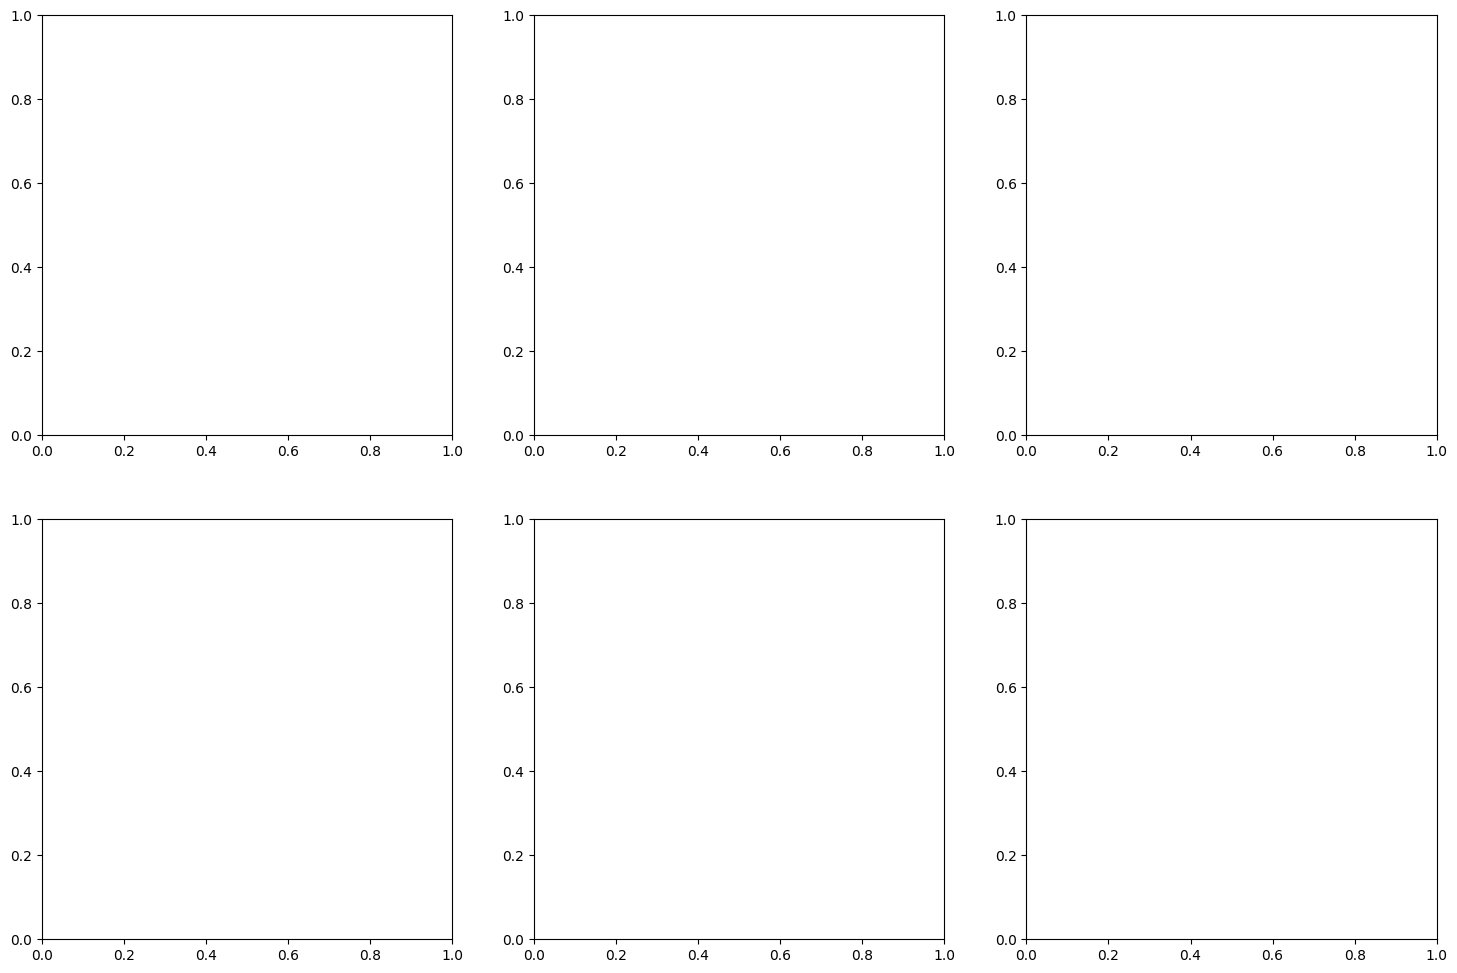

In [ ]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Metrics vs Threshold
ax1 = axes[0, 0]
ax1.plot(thresholds, precision[:-1], label='Precision', linewidth=2)
ax1.plot(thresholds, recall[:-1], label='Recall (Sensitivity)', linewidth=2)
ax1.plot(thresholds, f1_scores[:-1], label='F1-Score', linewidth=2)

# Mark important thresholds
ax1.axvline(x=optimal_f1_threshold, color='red', linestyle='--', alpha=0.7, label='Optimal F1')
ax1.axvline(x=high_sensitivity_threshold, color='green', linestyle='--', alpha=0.7, label='High Sensitivity')
ax1.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, label='Default')

ax1.set_xlabel('Decision Threshold')
ax1.set_ylabel('Score')
ax1.set_title('SVM: Metrics vs Decision Threshold', fontsize=12, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 1)

# 2. ROC Curve
ax2 = axes[0, 1]
ax2.plot(fpr, tpr, 'b-', linewidth=2, label=f'SVM ROC (AUC={roc_auc_score(y_test, y_proba_svm_best):.3f})')
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.5)

# Mark threshold points
for name, result in threshold_results_svm.items():
    if name in ['Default (0.5)', 'High Sensitivity', 'Optimal F1']:
        fpr_point = 1 - result['specificity']
        tpr_point = result['sensitivity']
        ax2.scatter(fpr_point, tpr_point, s=100, label=name)

ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('SVM ROC Curve with Key Thresholds', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Precision-Recall Curve
ax3 = axes[0, 2]
ax3.plot(recall, precision, 'g-', linewidth=2)
ax3.scatter(recall[optimal_f1_idx], precision[optimal_f1_idx], 
           color='red', s=100, zorder=5, label=f'Optimal F1 (th={optimal_f1_threshold:.3f})')
ax3.set_xlabel('Recall (Sensitivity)')
ax3.set_ylabel('Precision')
ax3.set_title('SVM Precision-Recall Curve', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Confusion Matrices for Key Thresholds
for idx, (name, threshold) in enumerate([('Default (0.5)', 0.5), 
                                         ('High Sensitivity', high_sensitivity_threshold),
                                         ('Optimal F1', optimal_f1_threshold)]):
    ax = axes[1, idx]
    result = threshold_results_svm[name]
    
    cm = np.array([[result['tn'], result['fp']], 
                   [result['fn'], result['tp']]])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False,
                xticklabels=['No Complication', 'Complication'],
                yticklabels=['No Complication', 'Complication'])
    ax.set_title(f'Confusion Matrix: {name}\nSensitivity={result["sensitivity"]:.1%}, '
                 f'Specificity={result["specificity"]:.1%}', fontsize=10)

plt.tight_layout()
plt.show()

Smote Logistic Regression


In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

# Create pipeline with SMOTE
smote_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=102)),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
])

# Train the model
print("Training Logistic Regression with SMOTE...")
smote_pipeline.fit(X_train, y_train)

# Get predictions
y_pred_smote = smote_pipeline.predict(X_test)
y_proba_smote = smote_pipeline.predict_proba(X_test)[:, 1]

# Initial performance with default threshold
print("\n" + "="*60)
print("LOGISTIC REGRESSION WITH SMOTE (Default Threshold = 0.5)")
print("="*60)
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba_smote):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_smote))

# Compare with original (without SMOTE)
print("\n" + "="*60)
print("COMPARISON: With vs Without SMOTE")
print("="*60)
print("Without SMOTE: ROC-AUC = 0.793, Sensitivity = 86%")
print(f"With SMOTE: ROC-AUC = {roc_auc_score(y_test, y_proba_smote):.3f}, "
      f"Sensitivity = {classification_report(y_test, y_pred_smote, output_dict=True)['1']['recall']:.1%}")



Training Logistic Regression with SMOTE...

LOGISTIC REGRESSION WITH SMOTE (Default Threshold = 0.5)
ROC-AUC Score: 0.820

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.58      0.73        62
           1       0.19      0.86      0.31         7

    accuracy                           0.61        69
   macro avg       0.58      0.72      0.52        69
weighted avg       0.89      0.61      0.68        69


COMPARISON: With vs Without SMOTE
Without SMOTE: ROC-AUC = 0.793, Sensitivity = 86%
With SMOTE: ROC-AUC = 0.820, Sensitivity = 85.7%


     age  height  weight    bmi  family_hist_cnt  chronic_meds_cnt  cholecystectomy_repair  hiatus_hernia_repair  CM_AIDS  CM_ANEMDEF  CM_ARTH  CM_CHF  CM_DEPRESS  CM_DM  CM_DMCX  CM_HTN_C  CM_HYPOTHY  CM_LIVER  CM_OBESE  CM_PSYCH  CM_SMOKE  CM_APNEA  CM_CHOLSTRL  CM_OSTARTH  CM_HPLD  gender_Male  procedure_category_BPD -DS  procedure_category_Mini gastric bypass (OAGB)  procedure_category_RYGBP  procedure_category_SADI  procedure_category_Sleeve  antibiotics_Augmentin  antibiotics_Clindamycin  antibiotics_Invanz  antibiotics_Kefsol  antibiotics_Rocephin
240   33     164   179.0  66.55                0                 0                     0.0                   1.0        0           0        0       0           0      0        0         0           0         0         0         0         0         0            0           0        0        False                       False                                          False                     False                    False                

antibiotics_Augmentin: 179 zeros out of 275 rows
antibiotics_Clindamycin: 263 zeros out of 275 rows
antibiotics_Invanz: 274 zeros out of 275 rows
antibiotics_Kefsol: 112 zeros out of 275 rows
antibiotics_Rocephin: 274 zeros out of 275 rows

Rows where ALL antibiotic dummies are 0 (i.e. original 0): 2


In [28]:
# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_smote)

# Find optimal threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

# Find threshold for 90% sensitivity
target_sensitivity = 0.90
sensitivity_idx = np.where(recall >= target_sensitivity)[0][-1] if np.any(recall >= target_sensitivity) else 0
high_sensitivity_threshold = thresholds[sensitivity_idx] if sensitivity_idx < len(thresholds) else 0.3

print(f"\nTHRESHOLD OPTIMIZATION RESULTS:")
print(f"Default threshold: 0.500")
print(f"Optimal F1 threshold: {optimal_threshold:.3f}")
print(f"High sensitivity (90%) threshold: {high_sensitivity_threshold:.3f}")
print(f"F1 at optimal: {f1_scores[optimal_idx]:.3f}")

# Plot threshold analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Precision-Recall curve
ax1.plot(recall, precision, 'b-', label='Precision-Recall', linewidth=2)
ax1.scatter(recall[optimal_idx], precision[optimal_idx], 
           color='red', s=100, zorder=5, label=f'Optimal F1 (th={optimal_threshold:.3f})')

# Add high sensitivity point
if sensitivity_idx < len(recall) - 1:
    ax1.scatter(recall[sensitivity_idx], precision[sensitivity_idx], 
               color='green', s=100, zorder=5, label=f'90% Sensitivity (th={high_sensitivity_threshold:.3f})')

ax1.set_xlabel('Recall (Sensitivity)')
ax1.set_ylabel('Precision')
ax1.set_title('Precision-Recall Curve (With SMOTE)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Threshold vs Metrics
ax2.plot(thresholds, precision[:-1], label='Precision', linewidth=2)
ax2.plot(thresholds, recall[:-1], label='Recall', linewidth=2)
ax2.plot(thresholds, f1_scores[:-1], label='F1-Score', linewidth=2)
ax2.axvline(x=optimal_threshold, color='red', linestyle='--', label='Optimal F1')
ax2.axvline(x=high_sensitivity_threshold, color='green', linestyle='--', label='High Sensitivity')
ax2.axvline(x=0.5, color='gray', linestyle='--', label='Default (0.5)')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Score')
ax2.set_title('Metrics vs Decision Threshold (With SMOTE)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 1)

plt.tight_layout()
plt.show()

NameError: name 'y_proba_smote' is not defined

In [30]:
from imblearn.over_sampling import (
    SMOTE, 
    BorderlineSMOTE, 
    SVMSMOTE, 
    ADASYN,
    RandomOverSampler,
    KMeansSMOTE
)
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve
from imblearn.pipeline import Pipeline as ImbPipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Define all oversampling methods
oversampling_methods = {
    'SMOTE (Original)': SMOTE(random_state=102),
    'Borderline-SMOTE': BorderlineSMOTE(random_state=102),
    'SVM-SMOTE': SVMSMOTE(random_state=102),
    'ADASYN': ADASYN(random_state=42),
    'Random OverSampling': RandomOverSampler(random_state=102),
    'KMeans-SMOTE': KMeansSMOTE(random_state=102, n_jobs=-1),
    'SMOTE + ENN': SMOTEENN(random_state=100),
    'SMOTE + Tomek': SMOTETomek(random_state=102)
}

# Store results
results = {}

print("="*80)
print("COMPARING ALL OVERSAMPLING METHODS")
print("="*80)

for name, sampler in oversampling_methods.items():
    print(f"\nTesting: {name}")
    print("-"*50)
    
    start_time = time.time()
    
    try:
        # Create pipeline
        pipeline = ImbPipeline([
            ('scaler', StandardScaler()),
            ('sampler', sampler),
            ('classifier', LogisticRegression(random_state=42, max_iter=1000))
        ])
        
        # Fit the model
        pipeline.fit(X_train, y_train)
        
        # Get predictions
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        roc_auc = roc_auc_score(y_test, y_proba)
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        # Calculate optimal threshold
        precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
        
        # Apply optimal threshold
        y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
        cm_optimal = confusion_matrix(y_test, y_pred_optimal)
        tn_opt, fp_opt, fn_opt, tp_opt = cm_optimal.ravel()
        
        # Store results
        results[name] = {
            'roc_auc': roc_auc,
            'default_sensitivity': tp / (tp + fn),
            'default_specificity': tn / (tn + fp),
            'optimal_threshold': optimal_threshold,
            'optimal_sensitivity': tp_opt / (tp_opt + fn_opt),
            'optimal_specificity': tn_opt / (tn_opt + fp_opt),
            'optimal_f1': f1_scores[optimal_idx],
            'time': time.time() - start_time,
            'y_proba': y_proba,
            'precision_recall': (precision, recall, thresholds)
        }
        
        print(f"ROC-AUC: {roc_auc:.3f}")
        print(f"Default threshold (0.5): Sens={tp/(tp+fn):.1%}, Spec={tn/(tn+fp):.1%}")
        print(f"Optimal threshold ({optimal_threshold:.3f}): Sens={tp_opt/(tp_opt+fn_opt):.1%}, "
              f"Spec={tn_opt/(tn_opt+fp_opt):.1%}, F1={f1_scores[optimal_idx]:.3f}")
        
    except Exception as e:
        print(f"Error with {name}: {str(e)}")
        results[name] = None

COMPARING ALL OVERSAMPLING METHODS

Testing: SMOTE (Original)
--------------------------------------------------
ROC-AUC: 0.645
Default threshold (0.5): Sens=57.1%, Spec=67.7%
Optimal threshold (0.263): Sens=85.7%, Spec=51.6%, F1=0.279

Testing: Borderline-SMOTE
--------------------------------------------------
ROC-AUC: 0.758
Default threshold (0.5): Sens=71.4%, Spec=74.2%
Optimal threshold (0.581): Sens=71.4%, Spec=82.3%, F1=0.435

Testing: SVM-SMOTE
--------------------------------------------------
ROC-AUC: 0.737
Default threshold (0.5): Sens=42.9%, Spec=82.3%
Optimal threshold (0.372): Sens=85.7%, Spec=72.6%, F1=0.400

Testing: ADASYN
--------------------------------------------------
ROC-AUC: 0.627
Default threshold (0.5): Sens=42.9%, Spec=67.7%
Optimal threshold (0.408): Sens=71.4%, Spec=61.3%, F1=0.278

Testing: Random OverSampling
--------------------------------------------------
ROC-AUC: 0.659
Default threshold (0.5): Sens=42.9%, Spec=67.7%
Optimal threshold (0.419): Sens=85

In [31]:
import joblib

# Example: Pick the model with the highest ROC-AUC
best_model_name = max(results, key=lambda k: results[k]['roc_auc'] if results[k] else -1)
best_sampler = oversampling_methods[best_model_name]

# Rebuild and fit the best pipeline
best_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('sampler', best_sampler),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])
best_pipeline.fit(X_train, y_train)

# Save to file
joblib.dump(best_pipeline, 'best_model_pipeline.pkl')
print(f"Saved model: {best_model_name}")

Saved model: Borderline-SMOTE



SUMMARY OF ALL OVERSAMPLING METHODS (Sorted by ROC-AUC)
             Method  ROC-AUC  Sensitivity (Default)  Specificity (Default)  Optimal Threshold  Sensitivity (Optimal)  Specificity (Optimal)  F1 (Optimal)  Time (s)
   SMOTE (Original)    0.820                  0.857                  0.581              0.702                  0.857                  0.919         0.667     0.061
      SMOTE + Tomek    0.820                  0.857                  0.581              0.701                  0.857                  0.919         0.667     0.070
             ADASYN    0.797                  0.857                  0.597              0.790                  0.571                  0.952         0.571     0.070
          SVM-SMOTE    0.772                  0.571                  0.887              0.513                  0.571                  0.887         0.444     0.139
        SMOTE + ENN    0.767                  0.857                  0.597              0.808                  0.714       

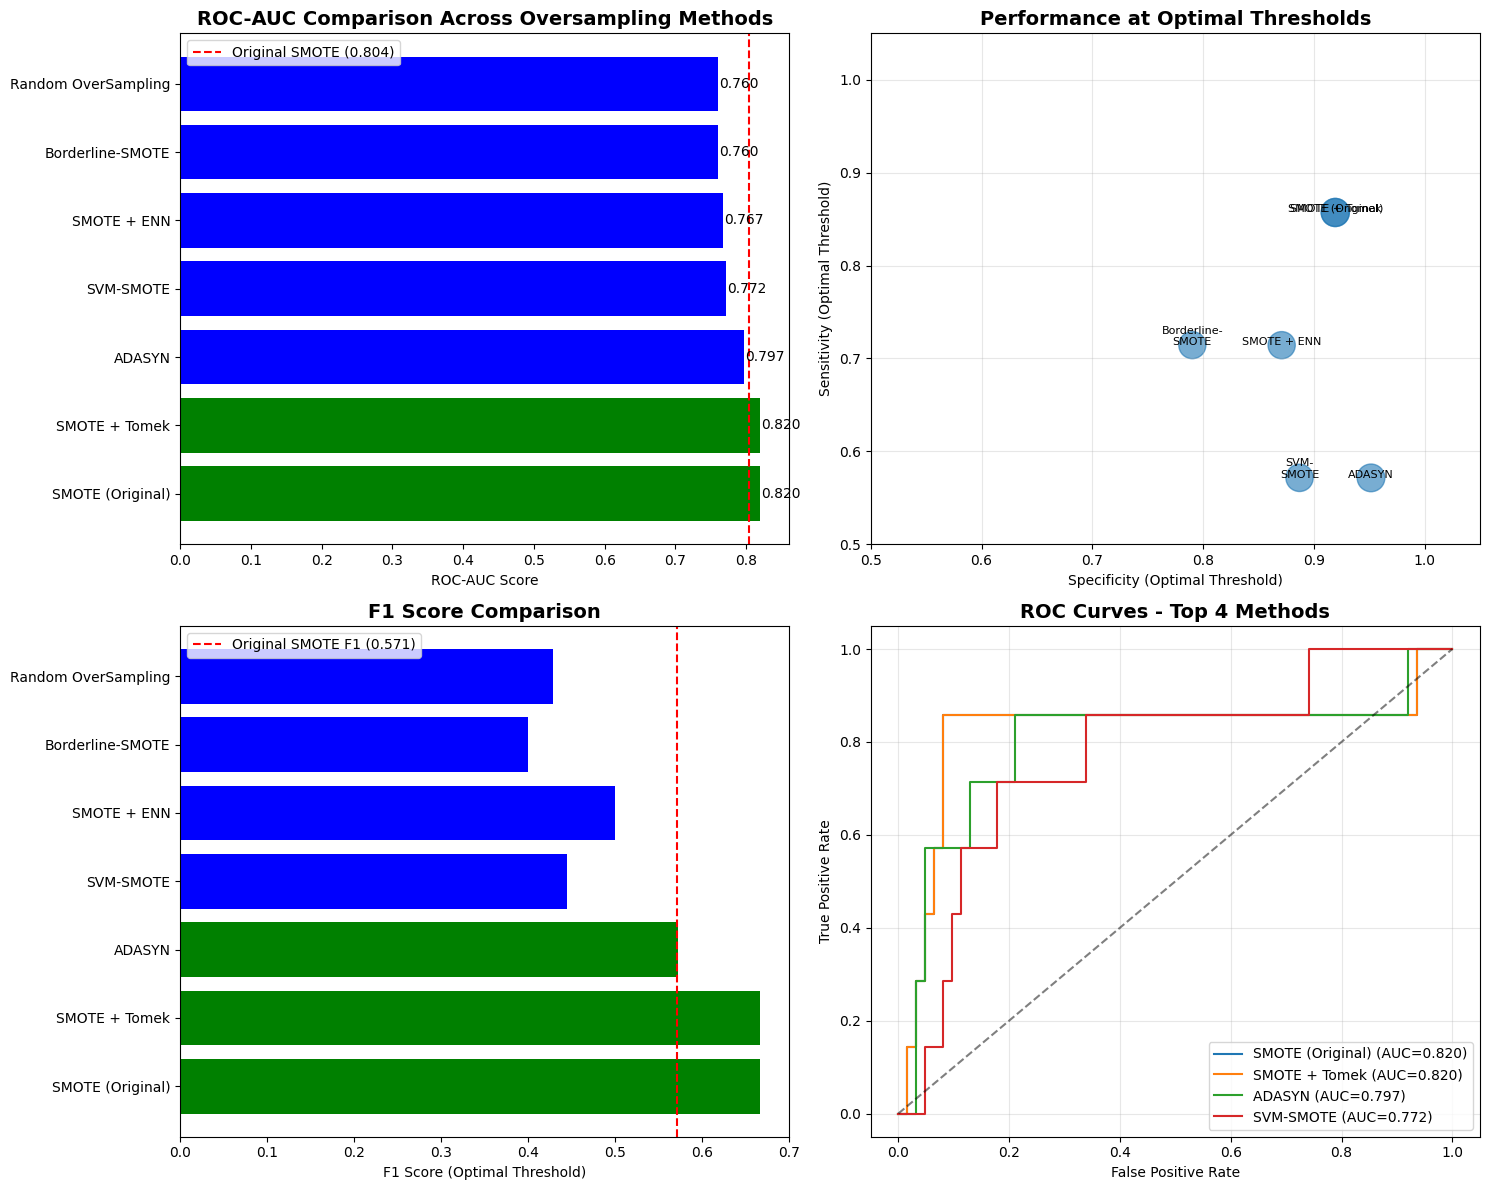

In [ ]:
# Create comparison dataframe
comparison_data = []
for method, result in results.items():
    if result is not None:
        comparison_data.append({
            'Method': method,
            'ROC-AUC': result['roc_auc'],
            'Sensitivity (Default)': result['default_sensitivity'],
            'Specificity (Default)': result['default_specificity'],
            'Optimal Threshold': result['optimal_threshold'],
            'Sensitivity (Optimal)': result['optimal_sensitivity'],
            'Specificity (Optimal)': result['optimal_specificity'],
            'F1 (Optimal)': result['optimal_f1'],
            'Time (s)': result['time']
        })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('ROC-AUC', ascending=False)

print("\n" + "="*100)
print("SUMMARY OF ALL OVERSAMPLING METHODS (Sorted by ROC-AUC)")
print("="*100)
print(comparison_df.to_string(index=False, float_format='%.3f'))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. ROC-AUC Comparison
ax1 = axes[0, 0]
methods = comparison_df['Method']
roc_scores = comparison_df['ROC-AUC']
colors = ['green' if score >= 0.804 else 'blue' for score in roc_scores]
bars = ax1.barh(methods, roc_scores, color=colors)
ax1.axvline(x=0.804, color='red', linestyle='--', label='Original SMOTE (0.804)')
ax1.set_xlabel('ROC-AUC Score')
ax1.set_title('ROC-AUC Comparison Across Oversampling Methods', fontsize=14, fontweight='bold')
ax1.legend()

# Add value labels
for i, (method, score) in enumerate(zip(methods, roc_scores)):
    ax1.text(score + 0.001, i, f'{score:.3f}', va='center')

# 2. Sensitivity vs Specificity Trade-off (Optimal Threshold)
ax2 = axes[0, 1]
ax2.scatter(comparison_df['Specificity (Optimal)'], 
           comparison_df['Sensitivity (Optimal)'], 
           s=comparison_df['ROC-AUC']*500, 
           alpha=0.6)

for idx, row in comparison_df.iterrows():
    ax2.annotate(row['Method'].replace('-', '-\n'), 
                (row['Specificity (Optimal)'], row['Sensitivity (Optimal)']),
                fontsize=8, ha='center')

ax2.set_xlabel('Specificity (Optimal Threshold)')
ax2.set_ylabel('Sensitivity (Optimal Threshold)')
ax2.set_title('Performance at Optimal Thresholds', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0.5, 1.05)
ax2.set_ylim(0.5, 1.05)

# 3. F1 Score Comparison
ax3 = axes[1, 0]
f1_scores = comparison_df['F1 (Optimal)']
colors = ['green' if score >= 0.571 else 'blue' for score in f1_scores]
ax3.barh(methods, f1_scores, color=colors)
ax3.axvline(x=0.571, color='red', linestyle='--', label='Original SMOTE F1 (0.571)')
ax3.set_xlabel('F1 Score (Optimal Threshold)')
ax3.set_title('F1 Score Comparison', fontsize=14, fontweight='bold')
ax3.legend()

# 4. ROC Curves for Top Methods
ax4 = axes[1, 1]
top_methods = comparison_df.head(4)['Method'].tolist()

for method in top_methods:
    if method in results and results[method] is not None:
        fpr, tpr, _ = roc_curve(y_test, results[method]['y_proba'])
        ax4.plot(fpr, tpr, label=f"{method} (AUC={results[method]['roc_auc']:.3f})")

ax4.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax4.set_xlabel('False Positive Rate')
ax4.set_ylabel('True Positive Rate')
ax4.set_title('ROC Curves - Top 4 Methods', fontsize=14, fontweight='bold')
ax4.legend(loc='lower right')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Report ALL Sampling Methods

In [ ]:
for name, res in results.items():
    if res is None: 
        continue
    thr     = res['optimal_threshold']
    y_pred  = (res['y_proba'] >= thr).astype(int)
    print(f"\n=== {name} (thr={thr:.3f}) ===")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))



=== SMOTE (Original) (thr=0.702) ===
[[57  5]
 [ 1  6]]
              precision    recall  f1-score   support

           0       0.98      0.92      0.95        62
           1       0.55      0.86      0.67         7

    accuracy                           0.91        69
   macro avg       0.76      0.89      0.81        69
weighted avg       0.94      0.91      0.92        69


=== Borderline-SMOTE (thr=0.468) ===
[[49 13]
 [ 2  5]]
              precision    recall  f1-score   support

           0       0.96      0.79      0.87        62
           1       0.28      0.71      0.40         7

    accuracy                           0.78        69
   macro avg       0.62      0.75      0.63        69
weighted avg       0.89      0.78      0.82        69


=== SVM-SMOTE (thr=0.513) ===
[[55  7]
 [ 3  4]]
              precision    recall  f1-score   support

           0       0.95      0.89      0.92        62
           1       0.36      0.57      0.44         7

    accuracy      

MULTIPLE MODELS WITH SMOTE + THRESHOLD OPTIMIZATION

Step 1: Data Preparation
----------------------------------------
Original data shape: (344, 28)
Categorical columns: ['gender', 'procedure_category', 'antibiotics']
After encoding shape: (344, 36)

Train set: (275, 36), Test set: (69, 36)
Class distribution - Train: [248  27], Test: [62  7]

Step 2: Training Models

Logistic Regression
--------------------------------------------------
ROC-AUC: 0.645
Default (0.5): Sensitivity=57.1%, Specificity=67.7%
Optimal (0.263): Sensitivity=85.7%, Specificity=51.6%, F1=0.279
Complications detected: 6/7

Random Forest
--------------------------------------------------
ROC-AUC: 0.682
Default (0.5): Sensitivity=14.3%, Specificity=100.0%
Optimal (0.330): Sensitivity=42.9%, Specificity=85.5%, F1=0.316
Complications detected: 3/7

Extra Trees
--------------------------------------------------
ROC-AUC: 0.606
Default (0.5): Sensitivity=0.0%, Specificity=93.5%
Optimal (0.070): Sensitivity=100.0%, Speci

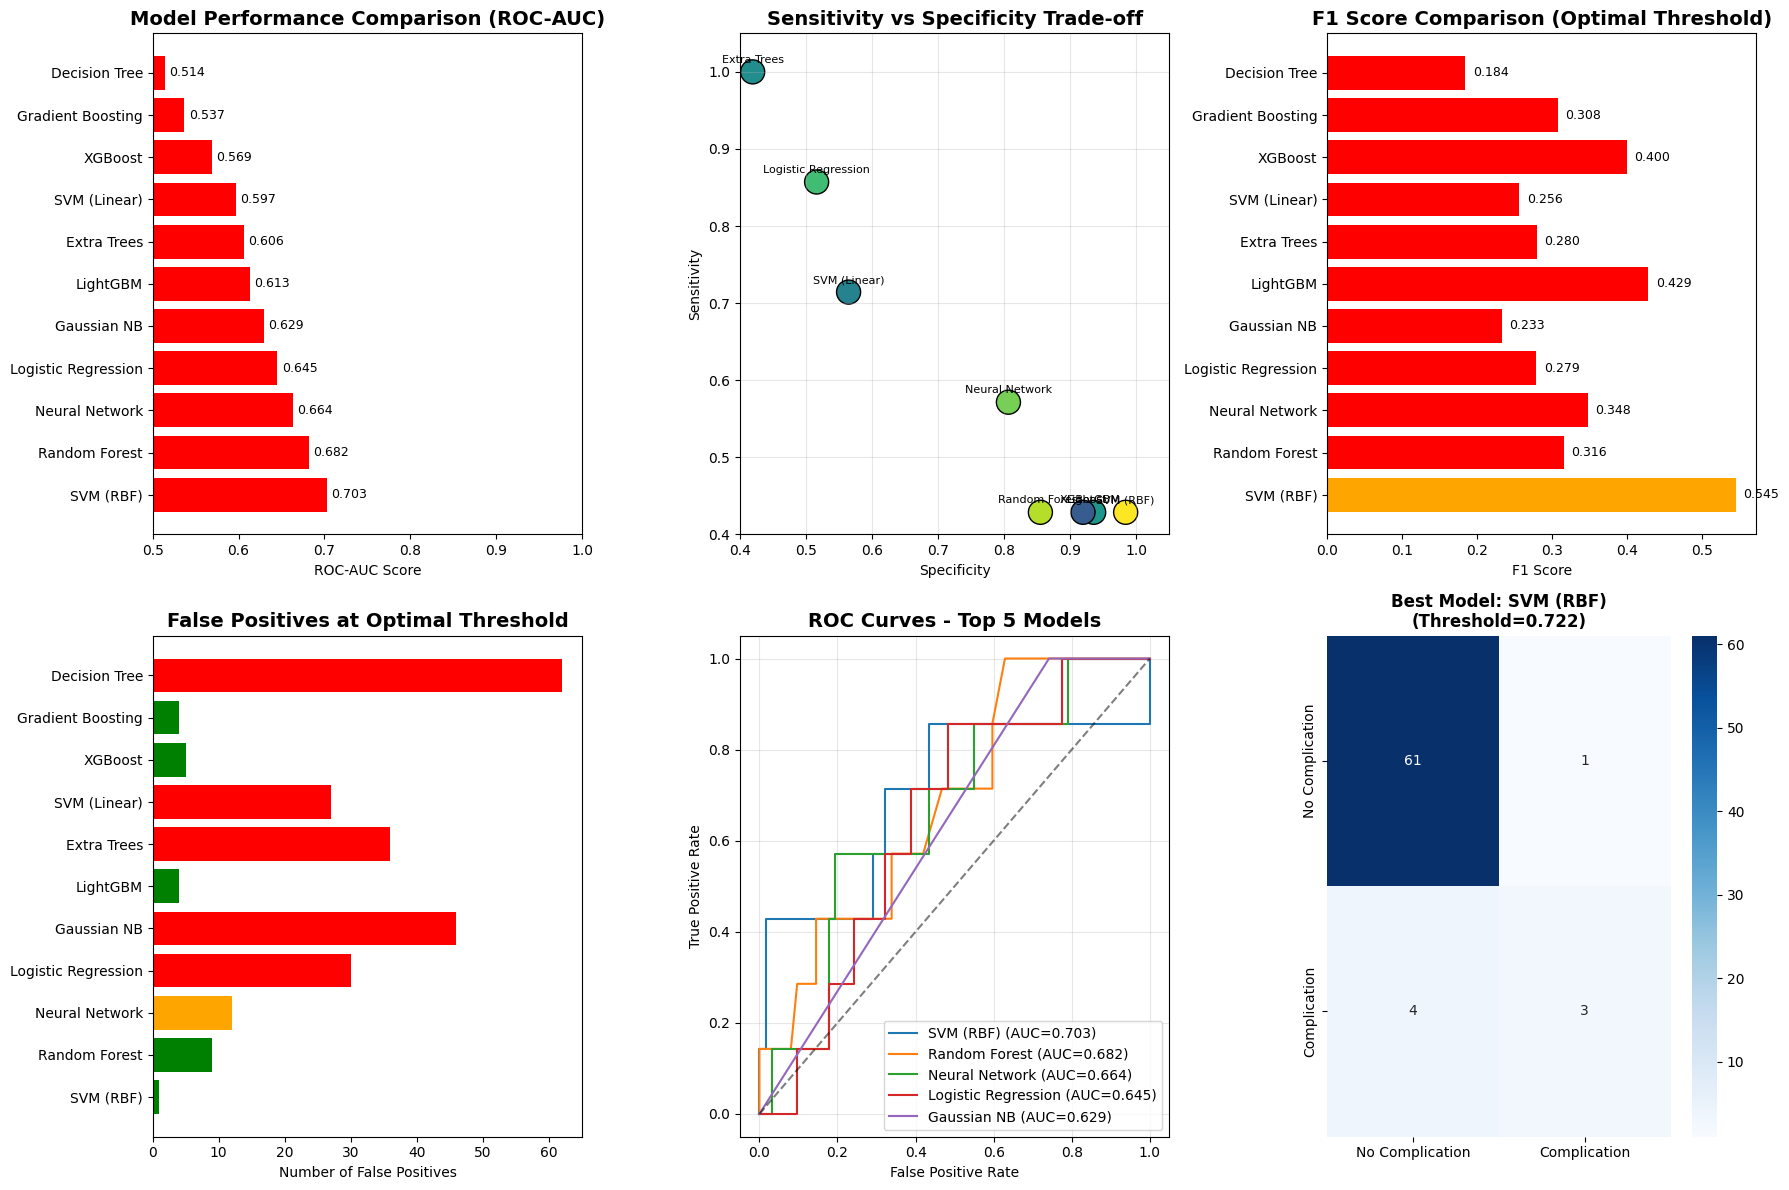


DETAILED ANALYSIS OF TOP 3 MODELS

SVM (RBF)
------------------------------------------------------------
Confusion Matrix at Optimal Threshold:
[[61  1]
 [ 4  3]]

Metrics:
ROC-AUC: 0.703
Optimal Threshold: 0.722
Sensitivity: 42.9%
Specificity: 98.4%
F1 Score: 0.545
Precision: 75.0%

Random Forest
------------------------------------------------------------
Confusion Matrix at Optimal Threshold:
[[53  9]
 [ 4  3]]

Metrics:
ROC-AUC: 0.682
Optimal Threshold: 0.330
Sensitivity: 42.9%
Specificity: 85.5%
F1 Score: 0.316
Precision: 25.0%

Neural Network
------------------------------------------------------------
Confusion Matrix at Optimal Threshold:
[[50 12]
 [ 3  4]]

Metrics:
ROC-AUC: 0.664
Optimal Threshold: 0.000
Sensitivity: 57.1%
Specificity: 80.6%
F1 Score: 0.348
Precision: 25.0%

DETAILED CLASSIFICATION REPORTS FOR ALL MODELS

Logistic Regression

Optimal Threshold: 0.263
ROC-AUC: 0.645

Confusion Matrix:
[[32 30]
 [ 1  6]]

Detailed Confusion Matrix:
                 Predicted


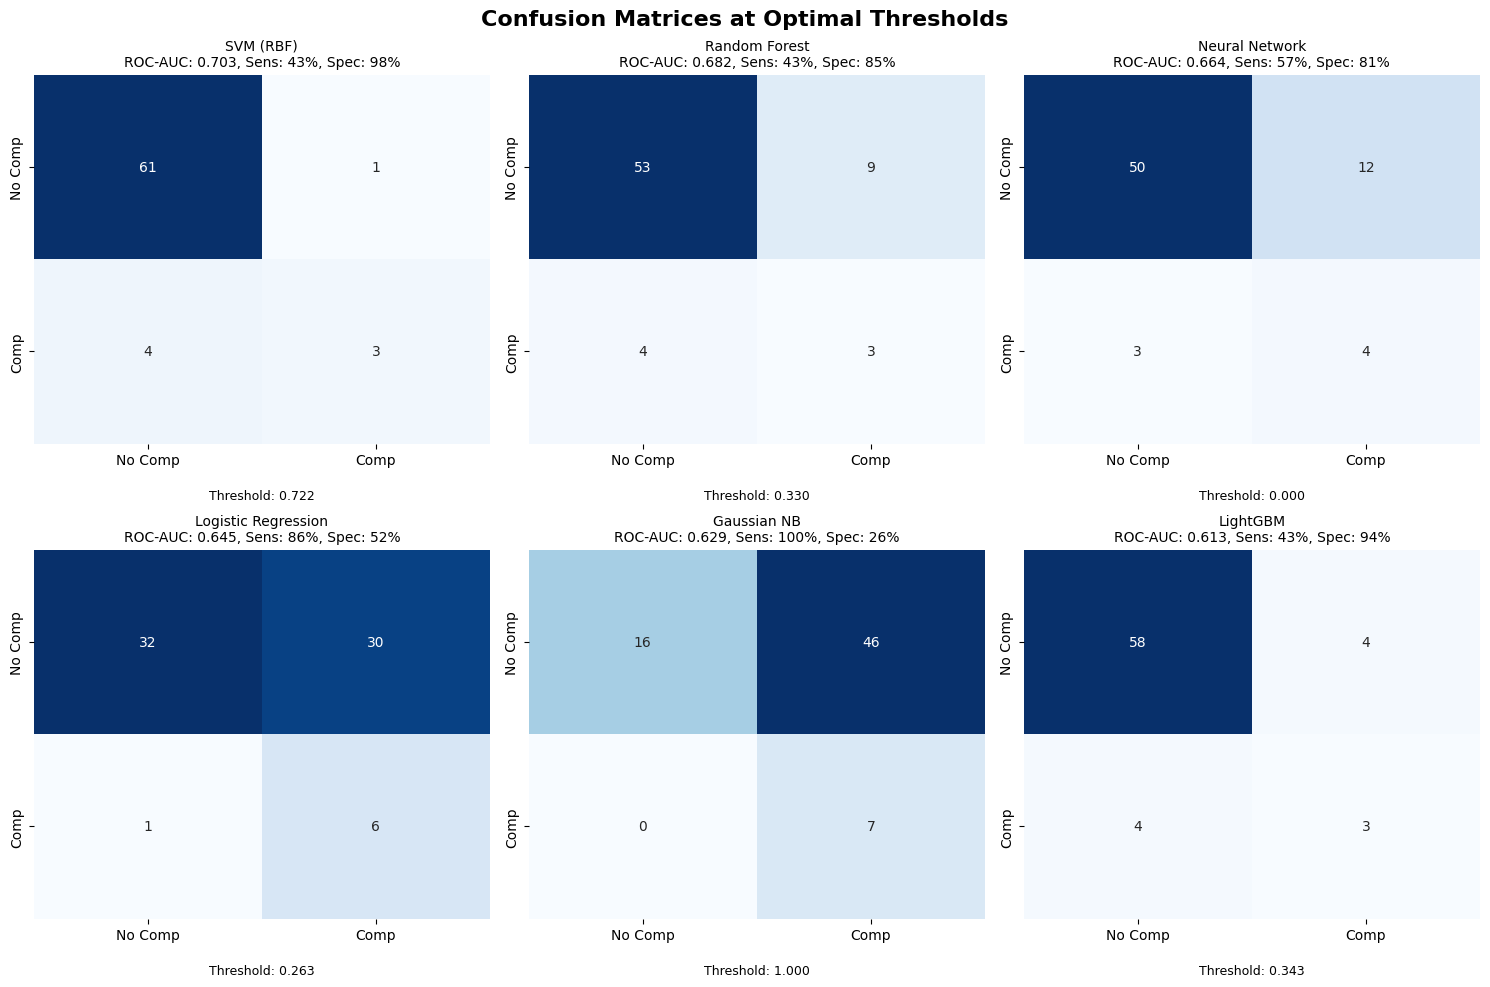


PERFORMANCE SUMMARY TABLE
              Model ROC-AUC Threshold  TP  TN  FP  FN Sensitivity Specificity Precision    F1 Accuracy
          SVM (RBF)   0.703     0.722   3  61   1   4       42.9%       98.4%     75.0% 0.545    92.8%
      Random Forest   0.682     0.330   3  53   9   4       42.9%       85.5%     25.0% 0.316    81.2%
     Neural Network   0.664     0.000   4  50  12   3       57.1%       80.6%     25.0% 0.348    78.3%
Logistic Regression   0.645     0.263   6  32  30   1       85.7%       51.6%     16.7% 0.279    55.1%
        Gaussian NB   0.629     1.000   7  16  46   0      100.0%       25.8%     13.2% 0.233    33.3%
           LightGBM   0.613     0.343   3  58   4   4       42.9%       93.5%     42.9% 0.429    88.4%
        Extra Trees   0.606     0.070   7  26  36   0      100.0%       41.9%     16.3% 0.280    47.8%
       SVM (Linear)   0.597     0.378   5  35  27   2       71.4%       56.5%     15.6% 0.256    58.0%
            XGBoost   0.569     0.322   3  57 

In [ ]:
# Import all necessary libraries
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_curve, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("MULTIPLE MODELS WITH SMOTE + THRESHOLD OPTIMIZATION")
print("="*80)

# Step 1: Prepare data (same as before)
print("\nStep 1: Data Preparation")
print("-"*40)

# Get original data
X = core_X_data.copy()
y = core_Y_data['complication'].values

print(f"Original data shape: {X.shape}")

# Encode categorical variables
categorical_cols = X.select_dtypes(include=['object']).columns
print(f"Categorical columns: {categorical_cols.tolist()}")

if len(categorical_cols) > 0:
    X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
    print(f"After encoding shape: {X_encoded.shape}")
else:
    X_encoded = X

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=200, stratify=y
)

print(f"\nTrain set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Class distribution - Train: {np.bincount(y_train)}, Test: {np.bincount(y_test)}")

# Step 2: Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, verbose=-1),
    'SVM (RBF)': SVC(kernel='rbf', probability=True, random_state=42),
    'SVM (Linear)': SVC(kernel='linear', probability=True, random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Gaussian NB': GaussianNB()
}

# Store results
results = {}

# Step 3: Train and evaluate models
print("\n" + "="*80)
print("Step 2: Training Models")
print("="*80)

for name, model in models.items():
    print(f"\n{name}")
    print("-"*50)
    
    try:
        # Create pipeline with SMOTE
        if name in ['SVM (RBF)', 'SVM (Linear)', 'Neural Network', 'Gaussian NB', 'Logistic Regression']:
            # These need scaling
            pipeline = ImbPipeline([
                ('scaler', StandardScaler()),
                ('smote', SMOTE(random_state=102)),  # Using the better random state
                ('model', model)
            ])
        else:
            # Tree-based models don't need scaling
            pipeline = ImbPipeline([
                ('smote', SMOTE(random_state=102)),  # Using the better random state
                ('model', model)
            ])
        
        # Train model
        pipeline.fit(X_train, y_train)
        
        # Get predictions
        y_pred_default = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:, 1]
        
        # Calculate ROC-AUC
        roc_auc = roc_auc_score(y_test, y_proba)
        
        # Default threshold metrics
        cm_default = confusion_matrix(y_test, y_pred_default)
        tn_def, fp_def, fn_def, tp_def = cm_default.ravel()
        
        # Find optimal threshold
        precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
        
        # Apply optimal threshold
        y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
        cm_optimal = confusion_matrix(y_test, y_pred_optimal)
        tn_opt, fp_opt, fn_opt, tp_opt = cm_optimal.ravel()
        
        # Store results
        results[name] = {
            'roc_auc': roc_auc,
            'default_threshold': 0.5,
            'default_sensitivity': tp_def / (tp_def + fn_def) if (tp_def + fn_def) > 0 else 0,
            'default_specificity': tn_def / (tn_def + fp_def) if (tn_def + fp_def) > 0 else 0,
            'default_f1': 2 * tp_def / (2 * tp_def + fp_def + fn_def) if (2 * tp_def + fp_def + fn_def) > 0 else 0,
            'optimal_threshold': optimal_threshold,
            'optimal_sensitivity': tp_opt / (tp_opt + fn_opt) if (tp_opt + fn_opt) > 0 else 0,
            'optimal_specificity': tn_opt / (tn_opt + fp_opt) if (tn_opt + fp_opt) > 0 else 0,
            'optimal_f1': f1_scores[optimal_idx] if optimal_idx < len(f1_scores) else 0,
            'tp_optimal': tp_opt,
            'fp_optimal': fp_opt,
            'fn_optimal': fn_opt,
            'tn_optimal': tn_opt,
            'y_proba': y_proba,
            'model': pipeline
        }
        
        print(f"ROC-AUC: {roc_auc:.3f}")
        print(f"Default (0.5): Sensitivity={tp_def/(tp_def+fn_def):.1%}, Specificity={tn_def/(tn_def+fp_def):.1%}")
        print(f"Optimal ({optimal_threshold:.3f}): Sensitivity={tp_opt/(tp_opt+fn_opt):.1%}, "
              f"Specificity={tn_opt/(tn_opt+fp_opt):.1%}, F1={f1_scores[optimal_idx]:.3f}")
        print(f"Complications detected: {tp_opt}/{tp_opt+fn_opt}")
        
    except Exception as e:
        print(f"Error: {str(e)}")
        results[name] = None

# Step 4: Create comparison dataframe
comparison_data = []
for name, result in results.items():
    if result is not None:
        comparison_data.append({
            'Model': name,
            'ROC-AUC': result['roc_auc'],
            'Optimal Threshold': result['optimal_threshold'],
            'Sensitivity': result['optimal_sensitivity'],
            'Specificity': result['optimal_specificity'],
            'F1 Score': result['optimal_f1'],
            'Complications Detected': f"{result['tp_optimal']}/{7}",
            'False Positives': result['fp_optimal']
        })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('ROC-AUC', ascending=False)

print("\n" + "="*100)
print("MODEL COMPARISON SUMMARY (Sorted by ROC-AUC)")
print("="*100)
print(comparison_df.to_string(index=False))

# Step 5: Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. ROC-AUC Comparison
ax1 = axes[0, 0]
models_sorted = comparison_df['Model']
roc_scores = comparison_df['ROC-AUC']
colors = ['green' if score >= 0.85 else 'orange' if score >= 0.80 else 'red' for score in roc_scores]
bars = ax1.barh(models_sorted, roc_scores, color=colors)
ax1.set_xlabel('ROC-AUC Score')
ax1.set_title('Model Performance Comparison (ROC-AUC)', fontsize=14, fontweight='bold')
ax1.set_xlim(0.5, 1.0)

# Add value labels
for i, score in enumerate(roc_scores):
    ax1.text(score + 0.005, i, f'{score:.3f}', va='center', fontsize=9)

# 2. Sensitivity vs Specificity
ax2 = axes[0, 1]
scatter = ax2.scatter(comparison_df['Specificity'], 
                     comparison_df['Sensitivity'], 
                     s=300, 
                     c=comparison_df['ROC-AUC'],
                     cmap='viridis',
                     edgecolors='black',
                     linewidth=1)

for idx, row in comparison_df.iterrows():
    ax2.annotate(row['Model'], 
                (row['Specificity'], row['Sensitivity']),
                fontsize=8, ha='center', va='bottom',
                xytext=(0, 5), textcoords='offset points')

ax2.set_xlabel('Specificity')
ax2.set_ylabel('Sensitivity')
ax2.set_title('Sensitivity vs Specificity Trade-off', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0.4, 1.05)
ax2.set_ylim(0.4, 1.05)

# 3. F1 Score Comparison
ax3 = axes[0, 2]
f1_scores_plot = comparison_df['F1 Score']
colors = ['green' if score >= 0.6 else 'orange' if score >= 0.5 else 'red' for score in f1_scores_plot]
ax3.barh(models_sorted, f1_scores_plot, color=colors)
ax3.set_xlabel('F1 Score')
ax3.set_title('F1 Score Comparison (Optimal Threshold)', fontsize=14, fontweight='bold')

# Add value labels
for i, score in enumerate(f1_scores_plot):
    ax3.text(score + 0.01, i, f'{score:.3f}', va='center', fontsize=9)

# 4. False Positives
ax4 = axes[1, 0]
fp_values = comparison_df['False Positives']
colors = ['green' if fp <= 10 else 'orange' if fp <= 15 else 'red' for fp in fp_values]
ax4.barh(models_sorted, fp_values, color=colors)
ax4.set_xlabel('Number of False Positives')
ax4.set_title('False Positives at Optimal Threshold', fontsize=14, fontweight='bold')

# 5. ROC Curves for Top 5 Models
ax5 = axes[1, 1]
from sklearn.metrics import roc_curve
top_5_models = comparison_df.head(5)['Model'].tolist()

for model_name in top_5_models:
    if model_name in results and results[model_name] is not None:
        y_proba = results[model_name]['y_proba']
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        ax5.plot(fpr, tpr, label=f"{model_name} (AUC={results[model_name]['roc_auc']:.3f})")

ax5.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax5.set_xlabel('False Positive Rate')
ax5.set_ylabel('True Positive Rate')
ax5.set_title('ROC Curves - Top 5 Models', fontsize=14, fontweight='bold')
ax5.legend(loc='lower right')
ax5.grid(True, alpha=0.3)

# 6. Confusion Matrix for Best Model
ax6 = axes[1, 2]
best_model_name = comparison_df.iloc[0]['Model']
best_result = results[best_model_name]

cm = np.array([[best_result['tn_optimal'], best_result['fp_optimal']], 
               [best_result['fn_optimal'], best_result['tp_optimal']]])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax6,
            xticklabels=['No Complication', 'Complication'],
            yticklabels=['No Complication', 'Complication'])
ax6.set_title(f'Best Model: {best_model_name}\n(Threshold={best_result["optimal_threshold"]:.3f})', 
              fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Step 6: Detailed analysis of top 3 models
print("\n" + "="*80)
print("DETAILED ANALYSIS OF TOP 3 MODELS")
print("="*80)

top_3_models = comparison_df.head(3)['Model'].tolist()

for model_name in top_3_models:
    if model_name in results:
        print(f"\n{model_name}")
        print("-"*60)
        result = results[model_name]
        
        # Show confusion matrix at optimal threshold
        cm = np.array([[result['tn_optimal'], result['fp_optimal']], 
                       [result['fn_optimal'], result['tp_optimal']]])
        
        print("Confusion Matrix at Optimal Threshold:")
        print(cm)
        print(f"\nMetrics:")
        print(f"ROC-AUC: {result['roc_auc']:.3f}")
        print(f"Optimal Threshold: {result['optimal_threshold']:.3f}")
        print(f"Sensitivity: {result['optimal_sensitivity']:.1%}")
        print(f"Specificity: {result['optimal_specificity']:.1%}")
        print(f"F1 Score: {result['optimal_f1']:.3f}")
        print(f"Precision: {result['tp_optimal']/(result['tp_optimal']+result['fp_optimal']):.1%}")
        # Add this after the existing code, or modify the "Detailed analysis of top 3 models" section

# Step 7: Show detailed classification reports for all models
print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORTS FOR ALL MODELS")
print("="*80)

for name, result in results.items():
    if result is not None:
        print(f"\n{'='*60}")
        print(f"{name}")
        print(f"{'='*60}")
        
        # Get predictions at optimal threshold
        y_pred_optimal = (result['y_proba'] >= result['optimal_threshold']).astype(int)
        
        print(f"\nOptimal Threshold: {result['optimal_threshold']:.3f}")
        print(f"ROC-AUC: {result['roc_auc']:.3f}")
        
        print("\nConfusion Matrix:")
        cm = confusion_matrix(y_test, y_pred_optimal)
        print(cm)
        
        # Visual confusion matrix
        print("\nDetailed Confusion Matrix:")
        print(f"                 Predicted")
        print(f"                 No    Yes")
        print(f"Actual No     [{cm[0,0]:3d}] [{cm[0,1]:3d}]")
        print(f"       Yes    [{cm[1,0]:3d}] [{cm[1,1]:3d}]")
        
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred_optimal, 
                                  target_names=['No Complication', 'Complication']))
        
        # Additional metrics
        tn, fp, fn, tp = cm.ravel()
        print("\nAdditional Metrics:")
        print(f"True Positives (TP): {tp}")
        print(f"True Negatives (TN): {tn}")
        print(f"False Positives (FP): {fp}")
        print(f"False Negatives (FN): {fn}")
        print(f"Sensitivity (Recall): {tp/(tp+fn):.1%}")
        print(f"Specificity: {tn/(tn+fp):.1%}")
        print(f"Precision: {tp/(tp+fp):.1%}" if (tp+fp) > 0 else "Precision: N/A")
        print(f"Negative Predictive Value: {tn/(tn+fn):.1%}" if (tn+fn) > 0 else "NPV: N/A")
        print(f"Accuracy: {(tp+tn)/(tp+tn+fp+fn):.1%}")

# Step 8: Create a summary visualization of confusion matrices for top models
print("\n" + "="*80)
print("CONFUSION MATRICES VISUALIZATION FOR TOP 6 MODELS")
print("="*80)

top_6_models = comparison_df.head(6)['Model'].tolist()
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, model_name in enumerate(top_6_models):
    if idx < 6 and model_name in results:
        result = results[model_name]
        
        # Get confusion matrix
        cm = np.array([[result['tn_optimal'], result['fp_optimal']], 
                       [result['fn_optimal'], result['tp_optimal']]])
        
        # Plot
        ax = axes[idx]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=['No Comp', 'Comp'],
                   yticklabels=['No Comp', 'Comp'],
                   cbar=False)
        
        # Add metrics as title
        ax.set_title(f'{model_name}\nROC-AUC: {result["roc_auc"]:.3f}, '
                    f'Sens: {result["optimal_sensitivity"]:.0%}, '
                    f'Spec: {result["optimal_specificity"]:.0%}',
                    fontsize=10)
        
        # Add threshold info
        ax.text(0.5, -0.15, f'Threshold: {result["optimal_threshold"]:.3f}', 
               transform=ax.transAxes, ha='center', fontsize=9)

plt.suptitle('Confusion Matrices at Optimal Thresholds', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Step 9: Create a performance summary table
print("\n" + "="*80)
print("PERFORMANCE SUMMARY TABLE")
print("="*80)

summary_data = []
for name, result in results.items():
    if result is not None:
        summary_data.append({
            'Model': name,
            'ROC-AUC': f"{result['roc_auc']:.3f}",
            'Threshold': f"{result['optimal_threshold']:.3f}",
            'TP': result['tp_optimal'],
            'TN': result['tn_optimal'],
            'FP': result['fp_optimal'],
            'FN': result['fn_optimal'],
            'Sensitivity': f"{result['optimal_sensitivity']:.1%}",
            'Specificity': f"{result['optimal_specificity']:.1%}",
            'Precision': f"{result['tp_optimal']/(result['tp_optimal']+result['fp_optimal']):.1%}" if (result['tp_optimal']+result['fp_optimal']) > 0 else "N/A",
            'F1': f"{result['optimal_f1']:.3f}",
            'Accuracy': f"{(result['tp_optimal']+result['tn_optimal'])/69:.1%}"
        })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('ROC-AUC', ascending=False)
print(summary_df.to_string(index=False))

# Step 10: Best model for clinical use
print("\n" + "="*80)
print("RECOMMENDATION FOR CLINICAL USE")
print("="*80)

best_model = comparison_df.iloc[0]
best_result = results[best_model['Model']]

print(f"Best Model: {best_model['Model']}")
print(f"ROC-AUC: {best_result['roc_auc']:.3f}")
print(f"Optimal Threshold: {best_result['optimal_threshold']:.3f}")
print(f"\nAt this threshold:")
print(f"- Detects {best_result['tp_optimal']} out of 7 complications ({best_result['optimal_sensitivity']:.1%})")
print(f"- False alarms in {best_result['fp_optimal']} out of 62 non-complications ({(best_result['fp_optimal']/62)*100:.1%})")
print(f"- Overall accuracy: {(best_result['tp_optimal']+best_result['tn_optimal'])/69:.1%}")

# Create a simple risk calculator example
print(f"\nRisk Score Interpretation:")
if best_result['optimal_threshold'] <= 0.3:
    print(f"- Low Risk: Probability < {best_result['optimal_threshold']/2:.1%}")
    print(f"- Moderate Risk: Probability {best_result['optimal_threshold']/2:.1%} - {best_result['optimal_threshold']:.1%}")
    print(f"- High Risk: Probability > {best_result['optimal_threshold']:.1%}")
else:
    print(f"- Low Risk: Probability < {best_result['optimal_threshold']*0.5:.1%}")
    print(f"- Moderate Risk: Probability {best_result['optimal_threshold']*0.5:.1%} - {best_result['optimal_threshold']:.1%}")
    print(f"- High Risk: Probability > {best_result['optimal_threshold']:.1%}")

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Print confusion matrix and classification report for every trained model
for model_name, result in results.items():
    if result is None:
        continue
    thresh = result['optimal_threshold']
    y_pred = (result['y_proba'] >= thresh).astype(int)
    
    print(f"\n=== {model_name} (Threshold = {thresh:.3f}) ===")
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=3))



=== Logistic Regression (Threshold = 0.702) ===
Confusion Matrix:
[[57  5]
 [ 1  6]]

Classification Report:
              precision    recall  f1-score   support

           0      0.983     0.919     0.950        62
           1      0.545     0.857     0.667         7

    accuracy                          0.913        69
   macro avg      0.764     0.888     0.808        69
weighted avg      0.938     0.913     0.921        69


=== Random Forest (Threshold = 0.300) ===
Confusion Matrix:
[[49 13]
 [ 2  5]]

Classification Report:
              precision    recall  f1-score   support

           0      0.961     0.790     0.867        62
           1      0.278     0.714     0.400         7

    accuracy                          0.783        69
   macro avg      0.619     0.752     0.634        69
weighted avg      0.891     0.783     0.820        69


=== Extra Trees (Threshold = 0.460) ===
Confusion Matrix:
[[57  5]
 [ 3  4]]

Classification Report:
              precision    rec


DETAILED THRESHOLD ANALYSIS FOR TOP 3 MODELS

XGBoost
------------------------------------------------------------
Threshold  Sensitivity  Specificity  Precision    F1       TP   FP
----------------------------------------------------------------------
0.200      57.1%        82.3%        26.7%        0.364    4    11
0.300      57.1%        85.5%        30.8%        0.400    4    9
0.400      57.1%        85.5%        30.8%        0.400    4    9
0.500      57.1%        90.3%        40.0%        0.471    4    6
0.531   ** 57.1%        90.3%        40.0%        0.471    4    6
0.700      28.6%        91.9%        28.6%        0.286    2    5
0.800      14.3%        93.5%        20.0%        0.167    1    4

SVM (RBF)
------------------------------------------------------------
Threshold  Sensitivity  Specificity  Precision    F1       TP   FP
----------------------------------------------------------------------
0.200      71.4%        69.4%        20.8%        0.323    5    19
0.300 

LOGISTIC REGRESSION WITH SMOTE - CLEAN RUN

Step 1: Data Preparation
----------------------------------------
Original data shape: (344, 28)
Original columns: ['gender', 'age', 'height', 'weight', 'bmi', 'family_hist_cnt', 'chronic_meds_cnt', 'procedure_category', 'antibiotics', 'cholecystectomy_repair', 'hiatus_hernia_repair', 'CM_AIDS', 'CM_ANEMDEF', 'CM_ARTH', 'CM_CHF', 'CM_DEPRESS', 'CM_DM', 'CM_DMCX', 'CM_HTN_C', 'CM_HYPOTHY', 'CM_LIVER', 'CM_OBESE', 'CM_PSYCH', 'CM_SMOKE', 'CM_APNEA', 'CM_CHOLSTRL', 'CM_OSTARTH', 'CM_HPLD']

Categorical columns found: ['gender', 'procedure_category', 'antibiotics']
After encoding shape: (344, 36)

Train set: (275, 36), Test set: (69, 36)
Train class distribution: [248  27]
Test class distribution: [62  7]

Step 2: Training Logistic Regression with SMOTE
----------------------------------------

--- SMOTE random_state = 42 ---
ROC-AUC: 0.804

Confusion Matrix:
[[41 21]
 [ 1  6]]

Classification Report:
              precision    recall  f1-score  

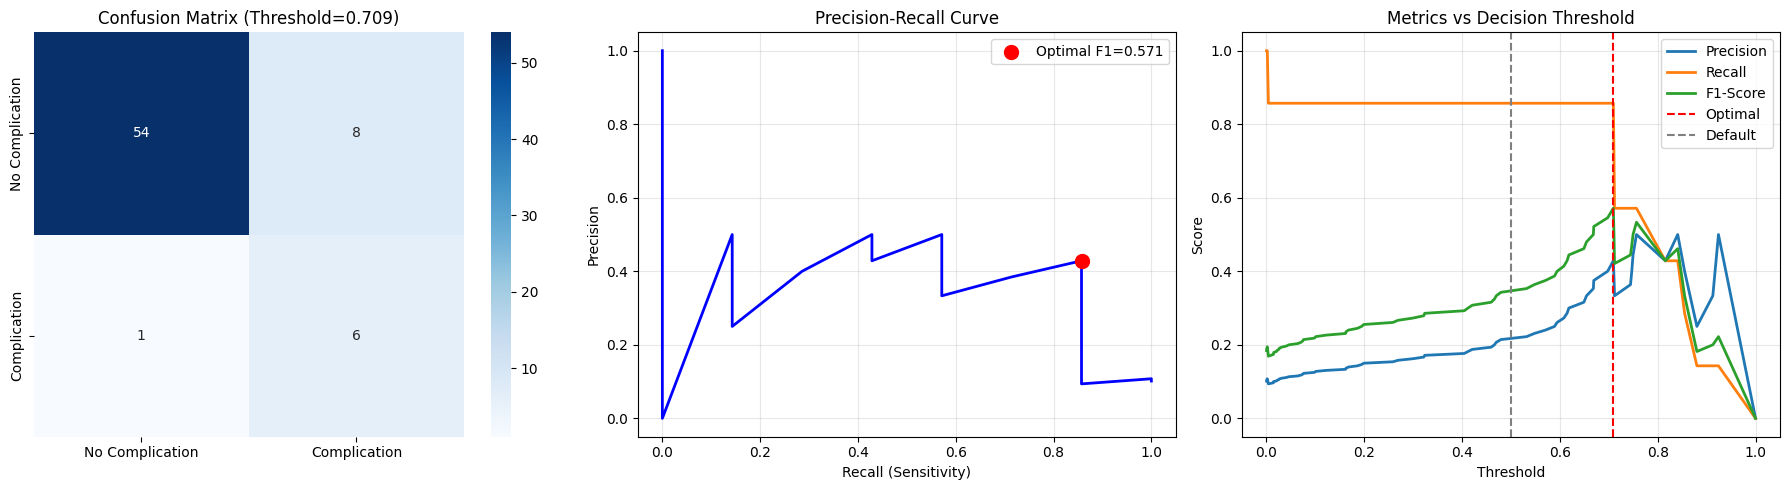


Step 4: Comparison with Class Weights (No SMOTE)
Class Weights ROC-AUC: 0.781

Class Weights Confusion Matrix:
[[38 24]
 [ 1  6]]

Class Weights Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.61      0.75        62
           1       0.20      0.86      0.32         7

    accuracy                           0.64        69
   macro avg       0.59      0.74      0.54        69
weighted avg       0.90      0.64      0.71        69


SUMMARY COMPARISON
SMOTE (rs=42) ROC-AUC: Check output above
SMOTE (rs=102) ROC-AUC: 0.804
Class Weights ROC-AUC: 0.781


In [ ]:
# For tree-based models, analyze feature importance
tree_models = ['Random Forest', 'Extra Trees', 'Gradient Boosting', 'XGBoost', 'LightGBM']

for model_name in tree_models:
    if model_name in results and results[model_name] is not None:
        model = results[model_name]['model'].named_steps['model']
        
        if hasattr(model, 'feature_importances_'):
            feature_importance = pd.DataFrame({
                'feature': X_train.columns,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            print(f"\nTop 10 features for {model_name}:")
            print(feature_importance.head(10))


Top 10 features for Random Forest:
                    feature  importance
3                       bmi    0.134611
2                    weight    0.113807
29  procedure_category_SADI    0.093688
1                    height    0.087178
0                       age    0.083655
7      hiatus_hernia_repair    0.073901
6    cholecystectomy_repair    0.066936
34       antibiotics_Kefsol    0.063856
5          chronic_meds_cnt    0.053080
18                 CM_OBESE    0.038709

Top 10 features for Extra Trees:
                    feature  importance
29  procedure_category_SADI    0.134686
3                       bmi    0.090745
2                    weight    0.078782
34       antibiotics_Kefsol    0.074903
0                       age    0.071163
1                    height    0.067057
6    cholecystectomy_repair    0.053654
5          chronic_meds_cnt    0.051892
7      hiatus_hernia_repair    0.045501
18                 CM_OBESE    0.044851

Top 10 features for Gradient Boosting:
          